<a href="https://colab.research.google.com/github/whyeon92/ESAA_YB/blob/Code_Study/ESAA_HW0503.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌4-9. 분류 실습 - 캐글 신용카드 사기 검출

In [1]:
#구글 코랩 환경 사용으로 드라이브 마운트 및 디렉터리 설정
from google.colab import drive
drive.mount('/content/gdrive/')

path = "/content/gdrive/My Drive/EuronData/"

Mounted at /content/gdrive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv(path + 'creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 데이터프레임을 복사한 뒤 Time 칼럼만 삭제하고 복사된 데이터 프레임 반환
def get_preprocessed_df(df= None):
  df_copy = df.copy()
  df_copy.drop('Time', axis = 1, inplace = True)
  return df_copy

In [4]:
#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df = None):
  #인자로 입력된 데이터프레임의 사전 데이터 가공이 완료된 복사 데이터 프레임 반환
  df_copy = get_preprocessed_df(df)
  #데이터프레임의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  #train_test_split()으로 학습과 테스트 데이터 분할
  #stratifiy = y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
  #학습과 테스트 데이터 세트 변환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
#지난 과제에서 정의한 get_clf_eval 불러오기
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

#3장에서 이용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946, F1: 0.7097, AUC: 0.9593


In [9]:
#인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [10]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(b_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

[LightGBM] [Warning] Unknown parameter: b_estimators
[LightGBM] [Warning] Unknown parameter: b_estimators
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] Unknown parameter: b_estimators
[LightGBM] [Warning] Unknown parameter: b_estimators
오차행렬
[[85289     6]
 [   38   110]]
정확도: 0.9995, 정밀도: 0.9483, 재현율: 0.7432, F1: 0.8333, AUC: 0.9717


## 데이터 분포도 변환 후 모델 학습/예측/평가

<Axes: xlabel='Amount', ylabel='Density'>

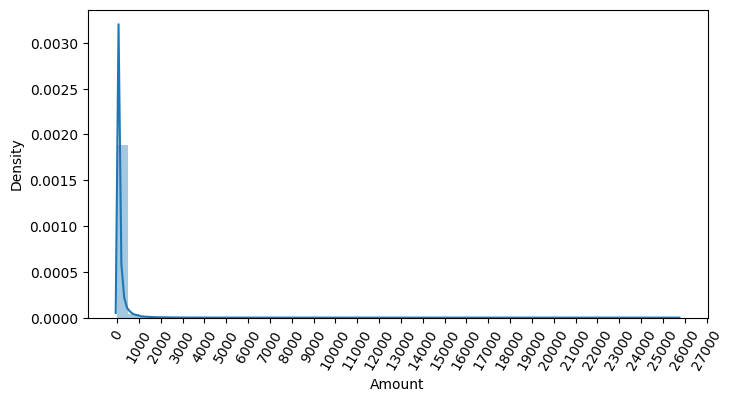

In [11]:
import seaborn as sns
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

In [13]:
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  #변환된 Amount를 Amount_Scaled로 피처명 변경 후 데이터 프레임 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  #기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  return df_copy

In [14]:
#Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)
print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs= -1)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.375443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [15]:
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  #넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  return df_copy

In [16]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Start training from score -6.360519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

## 이상치 데이터 제거 후 모델 학습/예측/평가

<Axes: >

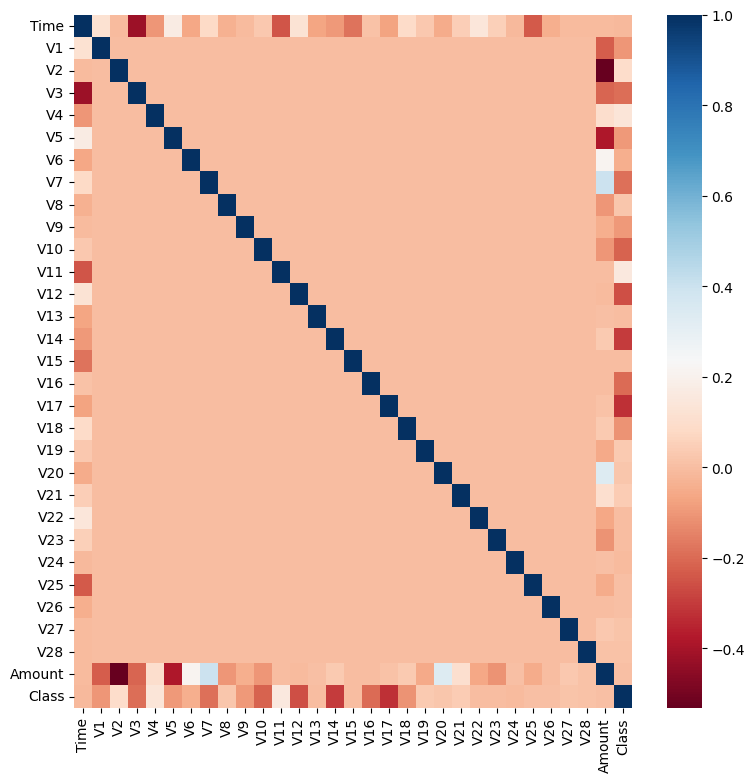

In [17]:
import seaborn as sns

plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap = 'RdBu')

In [20]:
import numpy as np

def get_outlier(df = None, column = None, weight = 1.5):
  #fraud에 해당하는 column 데이터만 추출, 1/4분위와  3/4 분위 지점을 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  #IQR를 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 데이터 프레임 인덱스 반환
  outlier_index = fraud[(fraud < lowest_val)|(fraud > highest_val)].index
  return outlier_index

In [21]:
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [23]:
#get_preprocessed_df()를 로그 변환 후 V14의 피처 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  #이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
  df_copy.drop(outlier_index, axis = 0, inplace = True)
  #행을 제거해야하니까 axis = 0으로 지정
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001715 -> initscore=-6.366350
[LightGBM] [Info] Start training from score -6.366350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

AttributeError: 'SMOTE' object has no attribute 'fit_sample'

https://www.inflearn.com/questions/355190/smote%EC%97%90%EC%84%9C-fit-sample-%EB%8A%94-%EC%82%AC%EC%9A%A9%ED%95%A0-%EC%88%98-%EC%97%86%EB%8A%94%EC%A7%80%EC%9A%94  
imbalanced-learn 패키지가 upgrade되면서, SMOTE 객체의 메소드가 fit_sample()이 아니라 fit_resample()로 변경되었습니다. fit_resample()로 사용하시면 됩니다.  
라고 하셔서 고쳤습니다~

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    199020
1    199020
Name: count, dtype: int64


In [26]:
lr_clf = LogisticRegression()
#ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


In [28]:
#지난 과제에서 정의한 precision_recall_curve_plot 불러오기
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  #X축을 threshold값으로 Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

  #threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  #x축, y축, label과 legend 그리고 grid 설정
  plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
  plt.legend();plt.grid
  plt.show()

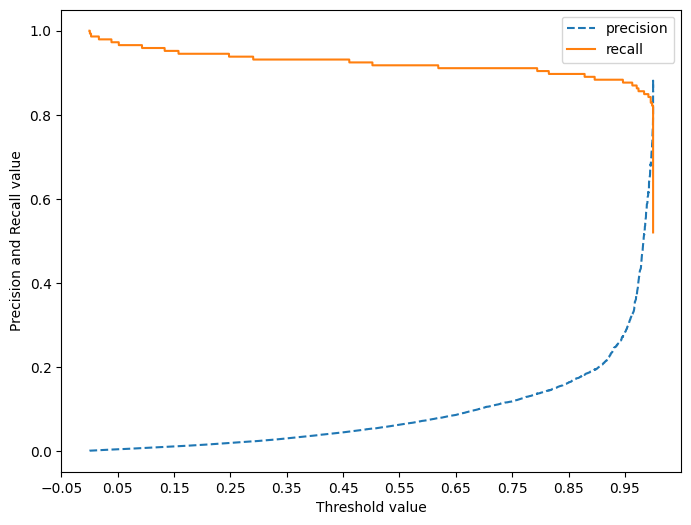

In [29]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [30]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

**[언더 샘플링과 오버 샘플링의 이해]**  
: 데이터의 레이블이 불균형할 때 예측 성능의 문제가 발생 가능  
(ex. 이상 데이터가 정상 데이터에 비해 과하게 적은 경우)  
-> 적절한 학습 데이터를 확보하기 위해 사용하는 게 언더 샘플링, 오버 샘플링  
  
**[📌언더 샘플링]**  
: 많은 데이터 세트를 적은 데이터 세트 수준으로 감소  
(= Minor 레이블에 해당하는 데이터에 맞춰 Major 레이블에 속하는 데이터를 줄임)  
👍과도하게 Major 레이블로 학습/예측하는 부작용을 줄임  
👎Major 레이블 데이터를 다수 줄여버리기 때문에 오히려 제대로 된 학습이 어려울 수 있음  
**[📌오버 샘플링]**  
: 적은 데이터 세트를 많은 데이터 수준으로 증식 (과적합 제어를 위해 아주 약간 피처를 바꿈)  
ex) SMOTE(Synthetic Minority Over-sampling Technique)  
-> Minor 레이블 데이터 세트에 있는 데이터의 KNN을 찾아 해당 데이터와 K개 이웃간의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이나는 새로운 데이터들을 생성  

# 📌4-10. 스태킹 앙상블

## 개별 스태킹 모델

In [31]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size = 0.2, random_state = 0)

In [33]:
#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors = 4)
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators = 100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C = 10)

In [35]:
#개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [39]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
#gbm_pred = gbm_clf.predict(X_test)
#어째 gbm은 학습 시키지도 않았는데 왜 나왔나 했다...

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다 부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.8947
에이다 부스트 정확도: 0.9561


In [40]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [41]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


## CV 세트 기반의 스태킹

In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  #지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits = n_folds, shuffle = False)
  #ValueError: Setting a random_state has no effect since shuffle is False.
  #You should leave random_state to its default (None), or set shuffle=True.
  #라고 셔플하지도 않을거면서 랜덤 스테이트 지정하지 말라는 말 같아서 랜덤 스테이트를 지웠습니다.
  #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
    #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [45]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


In [46]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis = 1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis = 1)
print('원본 학습 피처 데이터 Shape: ', X_train.shape, '원본 테스트 피처 Shape: ', X_test.shape)
print('스태킹 학습 피처 데이터 Shape: ', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape: ', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape:  (455, 30) 원본 테스트 피처 Shape:  (114, 30)
스태킹 학습 피처 데이터 Shape:  (455, 4) 스태킹 테스트 피처 데이터 Shape:  (114, 4)


In [47]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


: 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 머신러닝 알고리즘으로 최종 학습을 수행  
그리고 테스트 데이터를 기반으로 다시 최종 예측을 수행  
- 실제론 잘 안쓰여도 캐글 경연처럼 최대한 성능을 끌어올리기 위한 때에 쓰임  

[모델 로직]  
N개의 피처, M개의 관측 데이터 ➡️ k개의 개별 모델 학습/예측 ➡️ 모델별로 M개의 예측값 ➡️ k개의 알고리즘, M개의 예측값 ➡️ 해당 예측값들을 최종 모델의 train 데이터로 사용 ➡️ 최종 모델 학습밑 predict.
  
[CV 기반 스태킹]
1. 학습 데이터를 나눠 k개의 Fold 생성
2. for i in range(k), (k-i)번째 폴드를 검증 폴드로 삼고, 나머지 폴드들로 개별 모델 학습
3. 검증 폴드에 대한 예측값을 최종 메타 모델 학습 데이터로 사용
4. 위에서 학습시킨 모델로 검증 폴드에 대해서 예측, 그리고 해당 예측값은 최종 메타 모델의 테스트 데이터로 사용.
5. k개의 폴드, n개의 개별 모델, m개의 학습 데이터, x개의 테스트 데이터, p개의 피처가 있다고 가정.
 - 각 폴드에 m/k개의 데이터 지정
 - 첫번째 개별 모델의 첫번째 폴드 과정에선, 마지막 폴드를 제외한 모든 폴드를 가지고 학습, -> 마지막 폴드에 대한 예측 -> m/k개의 예측값 생성
 - 위의 과정을 하나의 모델에 대해 k번 반복 -> 하나의 개별 모델에서 m개의 예측값 나옴.
 - 이렇게 학습한 모델을 기반으로 테스트 데이터도 예측 -> x개의 테스트 데이터에 대한 예측값이 각 k개 나오게 됨 -> 평균 취하기
 - 그리고 이걸 n개의 모델에 대해 계속 반복하면 메타 모델에 사용할 m•n의 학습 데이터 생성.
 - 메타 모델에 사용할 x•n개의 테스트 데이터도 생성됨.
 - 그래서 결론적으로 메타 모델은 m•n의 메타 학습 데이터와 원본 학습 레이블로 학습 후 x•n의 메타 테스트 데이터로 최종 결과를 예측, 원본 테스트 레이블과 비교해 성능 평가.

# 📌4-11. 정리

분류에서 다룬 알고리즘
- 결정트리
- 랜덤 포레스트
- GBM
- XGBoost
- LightGBM
- 스태킹 앙상블